In [5]:
###########import packages##########
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn import ensemble
from sklearn import svm
from sklearn import neighbors
from sklearn import tree
from sklearn.linear_model import BayesianRidge
from sklearn.tree import ExtraTreeRegressor
from sklearn.tree import ExtraTreeClassifier
from sklearn import linear_model
from sklearn.preprocessing import label_binarize
from itertools import cycle
import lightgbm
import catboost
import xgboost
#import shap
from scipy import interp
#import seaborn as sns
from catboost import *
from sklearn.decomposition import PCA
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import r2_score
#%matplotlib
###########wrapping root mean square error for later calls##########
def compute_mae_mse_rmse(target,prediction):
    error = []
    for i in range(len(target)):
        error.append(target[i] - prediction[i])
    squaredError = []
    absError = []
    for val in error:
        squaredError.append(val * val)  # target-prediction之差平方
        absError.append(abs(val))  # 误差绝对值
    mae=sum(absError)/len(absError)  # 平均绝对误差MAE
    mse=sum(squaredError)/len(squaredError)  # 均方误差MSE
    RMSE=np.sqrt(sum(squaredError)/len(squaredError))
    R2=r2_score(target,prediction)
    return mae,mse,RMSE,R2
###########loading data##########
fdata=pd.read_csv('database_filled_CD.csv',encoding="gbk")
raw_data=fdata.loc[:,[
                      'Operating Temperature (℃)',#0
                      'Flow Rate (mL min-1)',#1    
                      'Active Area (cm2)', #2
                      'Ir wt. %',#3
                      'Ru wt.%',#4
                      'O wt. %',#5
                      'I/C in Anode',#6
                      'Pt wt. %',#7
                      'I/C in Cathode',#8  
                      'Anode Precious Metal Loading (mg cm-2 Ir/Ru/Pt/Pd)',#9
                      'Cathode Precious Metal Loading (mg cm-2 Pt/Pd)',#10
                      'Membrane Thickness (μm)',#11
                      'EW'#12
                        ]]
###########train test splitting##########
raw_param=raw_data.iloc[:,0:13]
print('ready')

ready


In [6]:
CD17=fdata.loc[:,['Current at 1.7 V']]

In [7]:
def summarize(list1):
    total=0
    for ele in range(0, len(list1)):
        total = total + list1[ele]
    return total

In [8]:
def gridsearch(model,param,algorithm_name):
    grid = GridSearchCV(model,param_grid=param,cv=5,n_jobs=-1)
    grid.fit(X_train,y_train)
    best_model=grid.best_estimator_
    result = best_model.predict(X_test)
    x_prediction_07=result
    y_real_07=y_test[:,0]
    x_prediction_07_series=pd.Series(x_prediction_07)
    y_real_07_series=pd.Series(y_real_07)
    
    result_train = best_model.predict(X_train)
    x_prediction_07_train=result_train
    y_real_07_train=y_train[:,0]
    x_prediction_07_series_train=pd.Series(x_prediction_07_train)
    y_real_07_series_train=pd.Series(y_real_07_train)
    
    ###########evaluating the regression quality##########
    corr_ann = round(x_prediction_07_series.corr(y_real_07_series), 5)
    error_val= compute_mae_mse_rmse(x_prediction_07,y_real_07)
    
    corr_ann_train = round(x_prediction_07_series_train.corr(y_real_07_series_train), 5)
    error_val_train= compute_mae_mse_rmse(x_prediction_07_train,y_real_07_train)
    
    print(algorithm_name)
    print(best_model.feature_importances_)
    print('Best Regressor:',grid.best_params_,'Best Score:', grid.best_score_)
    print(error_val,'TEST R2',error_val[3],'TEST CORR',corr_ann)
    print(error_val_train,'TRAIN R2',error_val_train[3],'TRAIN CORR',corr_ann_train)
    x_y_x=np.arange(0,3,0.1)
    x_y_y=np.arange(0,3,0.1)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(x_prediction_07,y_real_07,color='red',label=algorithm_name+' Test Set',alpha=0.75)
    ax.scatter(x_prediction_07_train,y_real_07_train,color='blue',label=algorithm_name+' Training Set',alpha=0.25,marker="^")
    ax.plot(x_y_x,x_y_y)
    plt.legend()
    plt.xlabel(u"Predicted_Current_Density (mA cm^-2)@1.7V (vs. RHE)")
    plt.ylabel(u"Real_Current_Density (mA cm^-2)@1.7V (vs. RHE)")
    plt.savefig('CD17 SEL %s.png' %algorithm_name)
    print('finished')

In [9]:
seed=51
X_train, X_test, y_train, y_test = train_test_split(raw_param, CD17, test_size=.15,random_state=seed)

In [10]:
train=pd.concat([X_train,y_train],axis=1)
train.to_csv('REG17_train.csv')
test=pd.concat([X_test,y_test],axis=1)
test.to_csv('REG17_test.csv')

In [6]:
from catboost import *
import shap
def shap_plot(model,param,algorithm_name):
    print(algorithm_name)
    SHAP_INPUT=raw_data.iloc[:,0:13]
    SHAP_OUTPUT=CD17
    grid = GridSearchCV(model,param_grid=param,cv=5,n_jobs=-100)
    grid.fit(X_train,y_train)
    best_model=grid.best_estimator_
    X_SHAP=SHAP_INPUT.values.astype(np.float32)
    y_SHAP=SHAP_OUTPUT
    if algorithm_name=='CatBoost':
        shap_values = best_model.get_feature_importance(Pool(X_SHAP,y_SHAP), type="ShapValues")
        shap_values=shap_values[:,:-1]
        shap.summary_plot(shap_values, SHAP_INPUT,max_display=100)
        global_importances = np.abs(shap_values).mean(0)
        print(global_importances)
    elif algorithm_name=='Random Forest' or algorithm_name=='Extra Tree'or algorithm_name=='Decision Tree'or algorithm_name=='AdaBoost':
        explainer = shap.TreeExplainer(best_model,X_SHAP)
        shap_values = explainer.shap_values(X_SHAP,check_additivity= False)
        shap.summary_plot(shap_values, SHAP_INPUT,max_display=100)
        global_importances = np.abs(shap_values).mean(0)
        print(global_importances)
    else:
        explainer = shap.TreeExplainer(best_model,X_SHAP)
        shap_values = explainer.shap_values(X_SHAP,check_additivity= False)
        shap.summary_plot(shap_values, SHAP_INPUT,max_display=100)
        global_importances = np.abs(shap_values).mean(0)
        print(global_importances)

D:\anaconda\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LightGBM
[ 856 1049]
Best Regressor: {} Best Score: 0.2905597939274096
(0.09820203027803558, 0.02073922212936497, 0.14401118751459893, -0.38877948242557414) TEST R2 -0.38877948242557414 TEST CORR 0.53542
(0.077926144707132, 0.012213193096400309, 0.11051331637590245, 0.04127154029732183) TRAIN R2 0.04127154029732183 TRAIN CORR 0.7831
finished
XGBoost
[0.50497097 0.495029  ]
Best Regressor: {} Best Score: 0.3161391066118678
(0.08292883107695086, 0.015649442443689893, 0.12509773156892132, 0.16683464638905532) TEST R2 0.16683464638905532 TEST CORR 0.67762
(0.01743587616283667, 0.0013023521861982032, 0.036088116966644344, 0.9499087506042655) TRAIN R2 0.9499087506042655 TRAIN CORR 0.97955
finished


KeyboardInterrupt: 

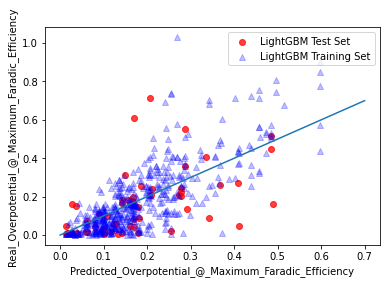

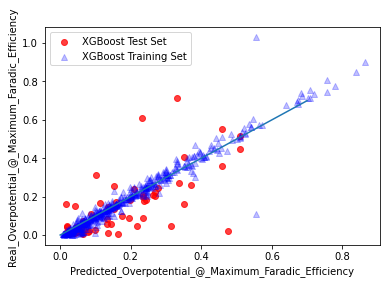

In [8]:
# ##########LGBM gridsearch CV for best hyperparameter##########
# model_LightGBMRegressor=lightgbm.LGBMRegressor(random_state=1,verbose=-1)
# param_light = {
# 'boosting_type':['gbdt','rf'],
# 'learning_rate':[0.001,0.002,0.004,0.005,0.006,0.008,0.01,0.02,0.04,0.06,0.05,0.06,0.08,0.1,0.12,0.14,0.15,0.16,0.18,0.2,0.4,0.5,0.6,0.8,1],
# 'subsample':[0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,1],
# 'n_estimators':[50,100,200,400],
# 'max_depth':[5,7,9,11,13,-1],
# 'reg_alpha':[0,0.001,0.01,0.0001,0.00001],
# 'reg_lambda':[0,0.001,0.01,0.0001,0.00001]
# }
# gridsearch(model_LightGBMRegressor,param_light,'LightGBM')

# ##########XGBoost gridsearch CV for best hyperparameter##########
# model_XGBRegressor=xgboost.XGBRegressor(objective='reg:squarederror',random_state=1,verbosity=0)
# param_xg = {
# 'booster':['gbtree'],
# 'learning_rate':[0.001,0.002,0.004,0.005,0.006,0.008,0.01,0.02,0.04,0.06,0.05,0.06,0.08,0.1,0.12,0.14,0.15,0.16,0.18,0.2,0.4,0.5,0.6,0.8,1],
# 'n_estimators':[100,200,400],
# 'max_depth':[5,7,9,11,13],
# 'subsample':[0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,1],
# 'reg_alpha':[0,0.001,0.01,0.0001,0.00001],
# 'reg_lambda':[0,0.001,0.01,0.0001,0.00001]
# }
# gridsearch(model_XGBRegressor,param_xg,'XGBoost')

##########CatBoost gridsearch CV for best hyperparameter##########
# model_CatRegressor=catboost.CatBoostRegressor(random_state=1,verbose=0)
# param_cat = {
# 'learning_rate':[0.001,0.002,0.004,0.005,0.006,0.008,0.01,0.02,0.04,0.06,0.05,0.06,0.08,0.1,0.12,0.14,0.15,0.16,0.18,0.2,0.4,0.5],
# 'n_estimators':[50,100,200,400],
# "boosting_type":["Plain"],
# 'max_depth':[5,7,9,11],
# 'subsample':[0.4,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,1],
# 'reg_lambda':[0,0.001,0.01,0.0001,0.00001]
# }
# gridsearch(model_CatRegressor,param_cat,'CatBoost')


# ###########GradientBoost gridsearch CV for best hyperparameter##########
# model_GradientBoostingRegressor = ensemble.GradientBoostingRegressor(random_state=1)
# ###########defining the parameters dictionary##########
# param_GB = {
# 'learning_rate':[0.001,0.002,0.004,0.005,0.006,0.008,0.01,0.02,0.04,0.06,0.05,0.06,0.08,0.1,0.12,0.14,0.15,0.16,0.18,0.2,0.4,0.5,0.6,0.8,1],
# 'n_estimators':[50,100,200,400],
# 'max_depth':[3,5,7,9,11,13,16],
# 'criterion':['friedman_mse','mae','mse'],
# 'max_features':['auto','sqrt','log2'],
# 'loss':['ls', 'lad', 'huber', 'quantile']
# }
# gridsearch(model_GradientBoostingRegressor,param_GB,'GradientBoost')

# ###########RandomForest gridsearch CV for best hyperparameter##########
# model_RandomForestRegressor = ensemble.RandomForestRegressor(random_state=1)
# ###########defining the parameters dictionary##########
# param_RF = {
# 'n_estimators':[50,100,200,400,None],
# 'max_depth':[3,5,7,9,11,None],
# 'criterion':['mse','mae'],
# 'max_features':['auto','sqrt','log2']
# }
# gridsearch(model_RandomForestRegressor,param_RF,'Random Forest')


# ###########Extra Tree gridsearch CV for best hyperparameter##########
# model_ExtraTreeRegressor = ExtraTreeRegressor(random_state=1)
# param_ET = {
# 'max_depth':[5,6,7,8,9,10,11,None],
# 'max_features':['auto','sqrt','log2'],
# 'criterion' : ["mse", "friedman_mse", "mae"],
# 'splitter' : [ "best",'random']
# }
# gridsearch(model_ExtraTreeRegressor,param_ET,'Extra Tree')


# ###########Decision Tree gridsearch CV for best hyperparameter##########
# model_DecisionTreeRegressor = tree.DecisionTreeRegressor(random_state=1)
# param_DT = {
# 'max_depth':[5,6,7,8,9,10,11,None],
# 'max_features':['auto','sqrt','log2'],
# 'criterion' : ["mse", "friedman_mse", "mae"],
# 'splitter' : [ "best",'random']
# }
# gridsearch(model_DecisionTreeRegressor,param_DT,'Decision Tree')


# ###########AdaBoost gridsearch CV for best hyperparameter##########
# model_AdaBoostRegressor = ensemble.AdaBoostRegressor(random_state=1)
# param_Ada = {
# 'n_estimators':[50,100,200,400,800],
# 'learning_rate':[0.001,0.002,0.004,0.005,0.006,0.008,0.01,0.02,0.04,0.06,0.05,0.06,0.08,0.1,0.12,0.14,0.15,0.16,0.18,0.2,0.4,0.5,0.6,0.8,1],
# 'loss':['linear', 'square', 'exponential']
# }
# gridsearch(model_AdaBoostRegressor,param_Ada,'AdaBoost')

Converting column-vector to 1d array


LightGBM
[379 288 197 192  57 137 513 267 369 587 272 202 121]
Best Regressor: {'boosting_type': 'gbdt', 'learning_rate': 0.06, 'max_depth': -1, 'n_estimators': 200, 'reg_alpha': 0, 'reg_lambda': 0.01, 'subsample': 0.4} Best Score: 0.7173376917594322
(0.1866818200888085, 0.09107790987706196, 0.3017911693159062, 0.824907005087318) TEST R2 0.824907005087318 TEST CORR 0.91684
(0.12483041420806744, 0.0506633768366074, 0.2250852657030384, 0.8775266168621247) TRAIN R2 0.8775266168621247 TRAIN CORR 0.9472
finished


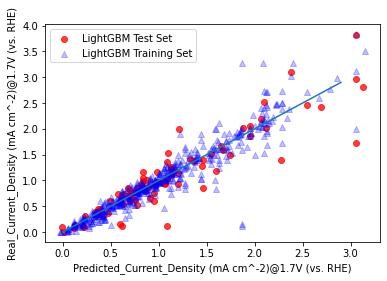

In [7]:
##########LGBM gridsearch CV for best hyperparameter##########
model_LightGBMRegressor=lightgbm.LGBMRegressor(random_state=1,verbose=-1)
param_light = {
'boosting_type':['gbdt'],
'learning_rate':[0.06],
'subsample':[0.4],
'n_estimators':[200],
'max_depth':[-1],
'reg_alpha':[0],
'reg_lambda':[0.01]
}
gridsearch(model_LightGBMRegressor,param_light,'LightGBM')

In [9]:
%matplotlib
shap_plot(model_LightGBMRegressor,param_light,'LightGBM')

Using matplotlib backend: Qt5Agg
LightGBM


Converting column-vector to 1d array
Converting column-vector to 1d array
Converting column-vector to 1d array
Converting column-vector to 1d array
Converting column-vector to 1d array
Converting column-vector to 1d array


[0.24989561 0.03319584 0.03358505 0.02884579 0.02570089 0.03408043
 0.1105227  0.04753709 0.08192581 0.05466356 0.03031298 0.25466226
 0.0109482 ]


In [10]:
##########XGBoost gridsearch CV for best hyperparameter##########
model_XGBRegressor=xgboost.XGBRegressor(objective='reg:squarederror',random_state=1,verbosity=0)
param_xg = {
'booster':['gbtree'],
'learning_rate':[0.05],
'n_estimators':[100],
'max_depth':[11],
'subsample':[0.4],
'reg_alpha':[0.01],
'reg_lambda':[0.001]
}
gridsearch(model_XGBRegressor,param_xg,'XGBoost')

XGBoost
[0.04795676 0.02251863 0.02785666 0.04420057 0.06249793 0.07068411
 0.03851399 0.04540989 0.06300753 0.03937636 0.0453732  0.41176417
 0.08084019]
Best Regressor: {'booster': 'gbtree', 'learning_rate': 0.05, 'max_depth': 11, 'n_estimators': 100, 'reg_alpha': 0.01, 'reg_lambda': 0.001, 'subsample': 0.4} Best Score: 0.7221739074436238
(0.16650455973804604, 0.06555765717706104, 0.25604229567995407, 0.8701995123868456) TEST R2 0.8701995123868456 TEST CORR 0.94122
(0.08252807716335474, 0.02859646226200141, 0.16910488538774215, 0.932312307637331) TRAIN R2 0.932312307637331 TRAIN CORR 0.97129
finished


In [11]:
shap_plot(model_XGBRegressor,param_xg,'XGBoost')

XGBoost
[0.22927793 0.03519978 0.02679524 0.03014489 0.03023556 0.02800331
 0.07431119 0.03190478 0.06470532 0.04993672 0.03737245 0.2660494
 0.03359671]


In [12]:
##########CatBoost gridsearch CV for best hyperparameter##########
model_CatRegressor=catboost.CatBoostRegressor(random_state=1,verbose=0)
param_cat = {

'max_depth':[11],
'boosting_type':['Plain'],
'subsample':[0.65],
'reg_lambda':[1e-05]
}
gridsearch(model_CatRegressor,param_cat,'CatBoost')

CatBoost
[22.54278848  5.29881099  4.77265049  3.70699679  2.64391475  4.25279644
  8.18125716  5.08688996 10.76501366  6.76409982  6.42954929 16.24742611
  3.30780606]
Best Regressor: {'boosting_type': 'Plain', 'max_depth': 11, 'reg_lambda': 1e-05, 'subsample': 0.65} Best Score: -170.56385043201973
(0.1690405971756589, 0.07777860327299446, 0.27888815549068136, 0.8654974868710803) TEST R2 0.8654974868710803 TEST CORR 0.93616
(0.041695634490611824, 0.022268242470892954, 0.14922547527447502, 0.9520261433233675) TRAIN R2 0.9520261433233675 TRAIN CORR 0.97698
finished


In [13]:
shap_plot(model_CatRegressor,param_cat,'CatBoost')

CatBoost
[0.18938246 0.04517269 0.03572892 0.02326016 0.02234845 0.02282931
 0.08270823 0.03171086 0.07395745 0.04259047 0.05063811 0.18567243
 0.04090974]


In [14]:
###########GradientBoost gridsearch CV for best hyperparameter##########
model_GradientBoostingRegressor = ensemble.GradientBoostingRegressor(random_state=1)
###########defining the parameters dictionary##########
param_GB = {
'learning_rate':[0.1],
'n_estimators':[100],
'max_depth':[5],
'criterion':['friedman_mse'],
'max_features':['sqrt'],
'loss':['huber']
}
gridsearch(model_GradientBoostingRegressor,param_GB,'GradientBoost')

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


GradientBoost
[0.22452977 0.05463993 0.03660731 0.02613243 0.02496846 0.03104915
 0.11647453 0.04024408 0.06724078 0.05429769 0.09197859 0.20375462
 0.02808267]
Best Regressor: {'criterion': 'friedman_mse', 'learning_rate': 0.1, 'loss': 'huber', 'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 100} Best Score: 0.7108411576043447
(0.18371509317836937, 0.08265003857741605, 0.2874891973229882, 0.8310383608434706) TEST R2 0.8310383608434706 TEST CORR 0.92321
(0.10653283119624454, 0.04368174354579728, 0.20900177881012708, 0.8922660911531438) TRAIN R2 0.8922660911531438 TRAIN CORR 0.95538
finished


In [15]:
shap_plot(model_GradientBoostingRegressor,param_GB,'GradientBoost')

GradientBoost


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[0.2290084  0.03786214 0.03804962 0.0194287  0.01910428 0.02650375
 0.09822203 0.03544154 0.06133557 0.04875768 0.0435948  0.20321346
 0.04743693]


In [16]:
###########RandomForest gridsearch CV for best hyperparameter##########
model_RandomForestRegressor = ensemble.RandomForestRegressor(random_state=1)
###########defining the parameters dictionary##########
param_RF = {
'n_estimators':[100],
'max_depth':[None],
'criterion':['mae'],
'max_features':['sqrt']
}
gridsearch(model_RandomForestRegressor,param_RF,'Random Forest')

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Random Forest
[0.18997082 0.07434808 0.04904081 0.04662399 0.02738247 0.05398737
 0.11106371 0.05290391 0.07903888 0.0802541  0.0640746  0.13390728
 0.03740399]
Best Regressor: {'criterion': 'mae', 'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 100} Best Score: 0.691811380770947
(0.17404994460114948, 0.06983007986923077, 0.2642538171327536, 0.8487343013381731) TEST R2 0.8487343013381731 TEST CORR 0.93756
(0.10996340473665978, 0.03728602025037211, 0.19309588356661597, 0.9036606591011853) TRAIN R2 0.9036606591011853 TRAIN CORR 0.96402
finished


In [17]:
shap_plot(model_RandomForestRegressor,param_RF,'Random Forest')

Random Forest


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[0.18112157 0.03254428 0.02494372 0.02363664 0.01816588 0.02467512
 0.08336675 0.02465157 0.04627007 0.03013945 0.03763897 0.19119998
 0.04167269]


In [18]:
###########Extra Tree gridsearch CV for best hyperparameter##########
model_ExtraTreeRegressor = ExtraTreeRegressor(random_state=1)
param_ET = {
'max_depth':[None],
'max_features':['auto'],
'criterion' : ["mae"],
'splitter' : [ 'random']
}
gridsearch(model_ExtraTreeRegressor,param_ET,'Extra Tree')

Extra Tree
[0.22051434 0.02532605 0.05738361 0.05632965 0.02014235 0.04135315
 0.08181394 0.04395221 0.05532359 0.08821221 0.06653326 0.14982658
 0.09328906]
Best Regressor: {'criterion': 'mae', 'max_depth': None, 'max_features': 'auto', 'splitter': 'random'} Best Score: 0.5999419685412419
(0.24053569804597713, 0.14552161451043166, 0.38147295383871144, 0.7461012354726578) TEST R2 0.7461012354726578 TEST CORR 0.8742
(0.032584276985743385, 0.022535090809877804, 0.15011692379567937, 0.9521768770406064) TRAIN R2 0.9521768770406064 TRAIN CORR 0.97671
finished


In [19]:
shap_plot(model_ExtraTreeRegressor,param_ET,'Extra Tree')

Extra Tree
[0.21591866 0.02019129 0.06208741 0.06603357 0.04019073 0.04631181
 0.05558103 0.01985703 0.05326829 0.06832956 0.04675306 0.29263551
 0.12058681]


In [20]:
###########Decision Tree gridsearch CV for best hyperparameter##########
model_DecisionTreeRegressor = tree.DecisionTreeRegressor(random_state=1)
param_DT = {
'max_depth':[None],
'max_features':['auto'],
'criterion' : ["mae"],
'splitter' : [ 'random']
}
gridsearch(model_DecisionTreeRegressor,param_DT,'Decision Tree')

Decision Tree
[0.22051434 0.02532605 0.05738361 0.05632965 0.02014235 0.04135315
 0.08181394 0.04395221 0.05532359 0.08821221 0.06653326 0.14982658
 0.09328906]
Best Regressor: {'criterion': 'mae', 'max_depth': None, 'max_features': 'auto', 'splitter': 'random'} Best Score: 0.5999419685412419
(0.24053569804597713, 0.14552161451043166, 0.38147295383871144, 0.7461012354726578) TEST R2 0.7461012354726578 TEST CORR 0.8742
(0.032584276985743385, 0.022535090809877804, 0.15011692379567937, 0.9521768770406064) TRAIN R2 0.9521768770406064 TRAIN CORR 0.97671
finished


In [21]:
shap_plot(model_DecisionTreeRegressor,param_DT,'Decision Tree')

Decision Tree
[0.21591866 0.02019129 0.06208741 0.06603357 0.04019073 0.04631181
 0.05558103 0.01985703 0.05326829 0.06832956 0.04675306 0.29263551
 0.12058681]


In [23]:
###########AdaBoost gridsearch CV for best hyperparameter##########
model_AdaBoostRegressor = ensemble.AdaBoostRegressor(random_state=1)
param_Ada = {
'n_estimators':[100],
'learning_rate':[0.002],
'loss':['linear']
}
gridsearch(model_AdaBoostRegressor,param_Ada,'AdaBoost')

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


AdaBoost
[0.28044229 0.00119587 0.00349198 0.01173266 0.01638631 0.01846052
 0.03890898 0.01009007 0.09972547 0.00339082 0.00719409 0.49589806
 0.01308289]
Best Regressor: {'learning_rate': 0.002, 'loss': 'linear', 'n_estimators': 100} Best Score: 0.5530491856188486
(0.33568742775836, 0.20601179299965192, 0.4538852200718282, 0.24929767699212024) TEST R2 0.24929767699212024 TEST CORR 0.80126
(0.3198560121230455, 0.19356823441159354, 0.4399639012596301, 0.2697317176764342) TRAIN R2 0.2697317176764342 TRAIN CORR 0.77852
finished


In [24]:
shap_plot(model_AdaBoostRegressor,param_Ada,'AdaBoost')

AdaBoost


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[0.21817301 0.00078283 0.00230304 0.00486527 0.01068171 0.00957571
 0.04004496 0.01300577 0.07076926 0.0034715  0.00341556 0.30852204
 0.01275109]
